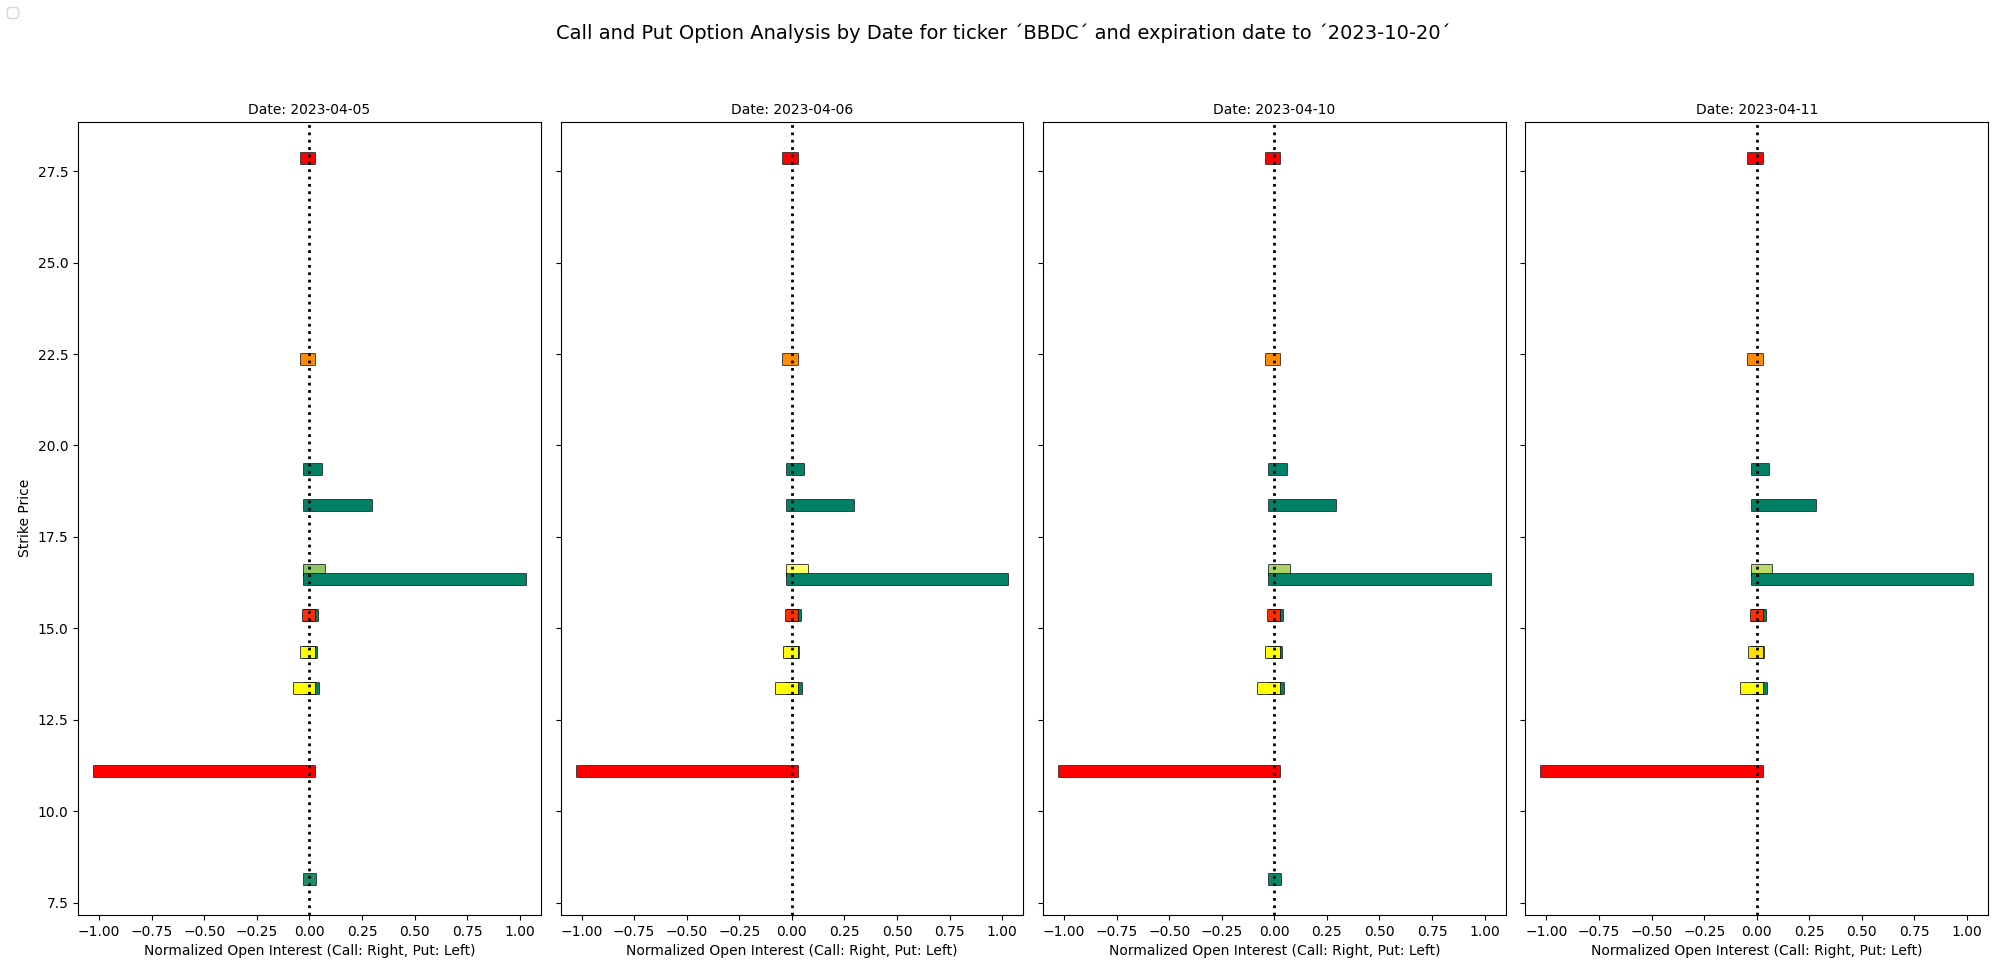

In [ ]:
import pandas as pd
from google.colab import files
from datetime import datetime, timedelta
from dateutil import parser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patheffects as PathEffects
import matplotlib as mpl
import numpy as np
from io import StringIO
import requests
import json
import re

class OPSatelite:
    def __init__(self, option_code, start_date, end_date, exp_date, group_by='Asst'):
        self.option_code = option_code
        self.group_by = group_by
        self.start_date = start_date
        self.end_date = end_date
        self.exp_date = exp_date


    def generate_urls(self):
        base_url = "https://www.b3.com.br/json/{date}/Posicoes/Empresa/SI_C_OPCPOSABEMP.json"
        date_range = pd.date_range(self.start_date, self.end_date, freq='B')
        brazilian_holidays = pd.Series(pd.to_datetime(['2023-01-01', '2023-02-20', '2023-02-21', '2023-04-07', '2023-04-21', '2023-05-01', '2023-06-08', '2023-09-07', '2023-10-12', '2023-11-02', '2023-11-15', '2023-12-25', '2023-12-31']))

        self.workdays = np.setdiff1d(date_range, brazilian_holidays)
        self.urls = [base_url.format(date=pd.Timestamp(day).strftime('%Y%m%d')) for day in self.workdays]


    def get_data(self):
        self.generate_urls()
        # Merge the CSV files
        dfs = []
        exp_date = ''.join([l if not l == '-' else '' for l in self.exp_date])
        for url, date in zip(self.urls, self.workdays):
            response = requests.get(url)
            json_content = json.loads(response.text)
            Empresa = json_content['Empresa']
            Empresa = {k: v for k, v in Empresa.items() if  k==self.option_code[0]}
            for key, comp_list in Empresa.items():
                for i, comp in enumerate(comp_list):
                    if self.option_code in comp['ser'] and comp['dtVen'] == exp_date:
                        _df = pd.DataFrame(comp, index=[i])
                        _df['Date'] = date
                        dfs.append(_df)
        merged_df = pd.concat(dfs)
        merged_df = merged_df.rename(columns={
            'ser': 'Series',
            'prEx': 'Strike',
            'nmEmp': 'Company',
            'poCob': 'Covered Position', # Coberto
            'posDe': 'Open Interest', # Descoberto (talvez seja o tamanho da barra)
            'qtdClTit': 'Number of Holder Clients', # Número de Titulares
            'posTr': 'Traded Position', # Trava
            'posTo': 'Total Position', # Coberto + Descoberto + Trava
            'qtdClLan': 'Number of Issuing Clients', # Número de Lançador
            'dtVen': 'Expiration Date',
            'tMerc': 'Market Type',
            'mer': 'Company Ticker',
            'espPap': 'Share Class'
        })

        self.op_df = merged_df


    def get_analysis(self):
        self.get_data()
        # Financial Position as a proxy for market bet size
        self.op_df['Financial Position'] = self.op_df['Open Interest'] * self.op_df['Strike']

        # Splitting the DataFrames by market type (assuming '70' for call and '80' for put)
        call_df = self.op_df[self.op_df['Market Type'] == '70'].copy()
        put_df = self.op_df[self.op_df['Market Type'] == '80'].copy()

        # Quality Ratios to assess the balance between issuing and holding clients
        call_df.loc[:, 'Call Quality Ratio'] = call_df['Number of Issuing Clients'] / call_df['Number of Holder Clients']
        put_df.loc[:, 'Put Quality Ratio'] = put_df['Number of Issuing Clients'] / put_df['Number of Holder Clients']

        # Financial Concentration to gauge the average position size per participant
        call_df.loc[:, 'Holder Call Financial Concentration'] = call_df['Financial Position'] / call_df['Number of Holder Clients']
        put_df.loc[:, 'Holder Put Financial Concentration'] = put_df['Financial Position'] / put_df['Number of Holder Clients']

        call_df.loc[:, 'Issuing Call Financial Concentration'] = call_df['Financial Position'] / call_df['Number of Issuing Clients']
        put_df.loc[:, 'Issuing Put Financial Concentration'] = put_df['Financial Position'] / put_df['Number of Issuing Clients']

        # Replace NaN values with 0 to avoid division by zero errors
        call_df.fillna(0, inplace=True)
        put_df.fillna(0, inplace=True)

        # Sentiment Concentration Ratios to capture the net sentiment (bullish vs bearish)
        call_df.loc[:, 'Call Sentiment Concentration Ratio'] = call_df['Holder Call Financial Concentration'] - call_df['Issuing Call Financial Concentration']
        put_df.loc[:, 'Put Sentiment Concentration Ratio'] = put_df['Holder Put Financial Concentration'] - put_df['Issuing Put Financial Concentration']

        # Combining Call and Put DataFrames for analysis
        self.call_df = call_df
        self.put_df = put_df

        # Min-Max normalization for both Call Quality Ratio and Open Interest
        self.call_df['Normalized Call Quality Ratio'] = (self.call_df['Call Quality Ratio'] - self.call_df['Call Quality Ratio'].min()) / (self.call_df['Call Quality Ratio'].max() - self.call_df['Call Quality Ratio'].min())
        self.call_df['Normalized Open Interest'] = (self.call_df['Open Interest'] - self.call_df['Open Interest'].min()) / (self.call_df['Open Interest'].max() - self.call_df['Open Interest'].min())

        # Min-Max normalization for both Put Quality Ratio and Open Interest
        self.put_df['Normalized Put Quality Ratio'] = (self.put_df['Put Quality Ratio'] - self.put_df['Put Quality Ratio'].min()) / (self.put_df['Put Quality Ratio'].max() - self.put_df['Put Quality Ratio'].min())
        self.put_df['Normalized Open Interest'] = (self.put_df['Open Interest'] - self.put_df['Open Interest'].min()) / (self.put_df['Open Interest'].max() - self.put_df['Open Interest'].min())

        # Additional analyses can be implemented here, such as:
        # 1. Time series analysis of the financial position, quality ratio, and sentiment concentration.
        # 2. Correlation analysis with underlying stock movements to identify lead/lag relationships.
        # 3. Anomaly detection using statistical methods or machine learning to flag potential insider trading activities.

        # This function now provides a comprehensive analysis framework for call and put options, focusing on financial positions, quality ratios, and sentiment concentration. It's tailored to identify unusual patterns that may indicate insider information-based trading.


    def plot_it(self):
        self.get_analysis()

        # Merging call and put dates and ensuring unique dates for plotting
        all_dates = np.unique(np.concatenate((self.call_df['Date'].unique(), self.put_df['Date'].unique())))
        n_dates = len(all_dates)

        # Setting up the plot
        fig, axes = plt.subplots(1, n_dates, figsize=(20, 10), sharey=True)

        mpl.rcParams['axes.facecolor'] = 'white'
        mpl.rcParams['text.color'] = 'black'
        mpl.rcParams['axes.edgecolor'] = 'black'
        mpl.rcParams['axes.labelcolor'] = 'black'
        mpl.rcParams['xtick.color'] = 'black'
        mpl.rcParams['ytick.color'] = 'black'
        mpl.rcParams['figure.facecolor'] = 'white'

        for i, date in enumerate(all_dates):
            ax = axes[i] if n_dates > 1 else axes
            call_df_date = self.call_df[self.call_df['Date'] == date]
            put_df_date = self.put_df[self.put_df['Date'] == date]

            # Plotting Call options
            for _, row in call_df_date.iterrows():
                # Quanto mais verde mais Call Quality Ratio
                call_color = plt.cm.summer(row['Normalized Call Quality Ratio'])
                # Quanto maior a barra, mais Open Interest de Call
                line, = ax.plot([0, row['Normalized Open Interest']], [row['Strike'], row['Strike']], color=call_color, linewidth=8, label='Call' if _ == 0 else "")
                line.set_path_effects([PathEffects.Stroke(linewidth=9, foreground='black'), PathEffects.Normal()])

            # Plotting Put options
            for _, row in put_df_date.iterrows():
                # Quanto mais verde mais Put Quality Ratio
                put_color = plt.cm.autumn(row['Normalized Put Quality Ratio'])
                # Quanto maior a barra, mais Open Interest de Put
                line, = ax.plot([0, -row['Normalized Open Interest']], [row['Strike'], row['Strike']], color=put_color, linewidth=8, label='Put' if _ == 0 else "")
                line.set_path_effects([PathEffects.Stroke(linewidth=9, foreground='black'), PathEffects.Normal()])

            ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
            ax.set_title(f'Date: {str(date)[:10]}', fontsize=10)
            ax.set_xlabel('Normalized Open Interest (Call: Right, Put: Left)')

        axes[0].set_ylabel('Strike Price')
        plt.suptitle(f'Call and Put Option Analysis by Date for ticker ´{self.option_code}´ and expiration date to ´{self.exp_date}´', fontsize=14, color='black')

        # Adding a legend to clarify colors
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper left')

        # Adjust the layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Show the plot
        plt.show()


if __name__ == "__main__":
    OP = OPSatelite('BBDC', '2023-04-05', '2023-04-11', exp_date='2023-10-20')
    OP = OP.plot_it()